<a href="https://colab.research.google.com/github/jrostek/horizon_finding/blob/main/horizon_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib import rc
from skimage.feature import canny
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import hough_line, hough_line_peaks
import os
from math import sqrt

In [ ]:
root_dir = "/content/drive/My Drive/horizon_finding/"
input_images = [root_dir+'input_images/'+img for img in os.listdir(root_dir+'input_images')]
# setting colormap of images to gray
rc('image', cmap='gray')

In [ ]:
def find_lines(im):
  """ Preprocesses the image and finds straight lines """
  plt.figure(figsize=(24, 24))
  plt.suptitle("Przygotowywanie obrazu do wykrycia horyzontu")
  # converting image to grayscale
  gray = im.convert('L')
  # plotting its histogram
  gray_np = np.array(gray)
  plt.subplot(321)
  plt.imshow(gray_np)
  plt.title("Obraz wejściowy w skali szarości")
  plt.subplot(322)
  plt.hist(gray_np.ravel(), 256, [0, 256])
  plt.title("Histogram obrazu wejściowego")
  plt.xlabel("Wartości pikseli")
  plt.ylabel("Ilość pikseli")
  # strongly blurring the image
  blurred = gaussian(gray_np,sigma=10)
  plt.subplot(323)
  plt.imshow(blurred)
  plt.title("Obraz silnie rozmyty")
  plt.subplot(324)
  plt.hist(blurred.ravel())
  plt.title("Histogram rozmytego obrazu")
  plt.xlabel("Wartości pikseli")
  plt.ylabel("Ilość pikseli")
  # binarizing the image
  thresh = threshold_otsu(blurred)
  binary = blurred > thresh
  plt.subplot(325)
  plt.imshow(binary)
  plt.title("Obraz zbinaryzowany")
  # performing canny edge detection
  edges = canny(binary)
  plt.subplot(326)
  plt.imshow(edges)
  plt.title("Krawędzie obrazu wykryte metodą Canny'ego")
  plt.show()
  # hough transform to get straight lines in images
  h, theta, d = hough_line(edges)
  return binary,hough_line_peaks(h,theta,d,num_peaks=50)

In [ ]:
def pick_horizon(im, h, theta, d):
  """ Picks horizon line from lines marked by Hough Transform
  
  Keyword arguments:
  im -- preprocessed image
  h -- standard Hough transform matrix
  theta -- angles of lines 
  d -- distances of lines from origin
  """
  rows, cols = im.shape
  xf1,xf2,yf1,yf2 = 0,0,0,0
  anglef = 0
  max_diff = 0
  im_copy = Image.fromarray((im.copy()*255).astype(np.uint8)).convert('L')
  for angle, dist in zip(theta, d):
    # calculating coordinates of line beginning and end
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    x1 = 0
    x2 = cols
    y1 = int((dist - (x1*cos_a))/sin_a)
    y2 = int((dist - (x2*cos_a))/sin_a)
    if y1 < 0 or y1 > rows or y2 < 0 or y2 > rows:
      y1 = 0
      y2 = rows
      x1 = int((dist + (y1*sin_a))/cos_a)
      x2 = int((dist + (y2*sin_a))/cos_a)
    mid_x = int((x1+x2)/2)
    mid_y = int((y1+y2)/2)
    # drawing the line
    #draw = ImageDraw.Draw(im_copy)
    #draw.line([x1,y1,x2,y2], fill=150, width=8)
    angle_deg = np.rad2deg(angle)
    rot_angle = 90-abs(angle_deg)
    if angle_deg > 0:
      rot_angle = -rot_angle
    # rotate image by angle
    im_rot = np.asarray(im_copy.rotate(rot_angle))
    sin_rot_a = np.sin(np.deg2rad(angle))
    cos_rot_a = np.cos(np.deg2rad(angle))
    x = int(mid_x*cos_rot_a - mid_y*sin_rot_a)
    y = int(mid_y*cos_rot_a + mid_x*sin_rot_a)
    # ignore the line if one part of the cut is too small
    if y < 10 or y > im_rot.shape[0]-10:
      continue
    # divide rotated image based on the potential horizon line
    cut1 = im_rot[:y,:]
    cut2 = im_rot[y:,:]
    # calculate difference of parameters in the cuts
    mean_cut1 = int(np.mean(cut1))
    mean_cut2 = int(np.mean(cut2))
    diff = abs(mean_cut1 - mean_cut2)
    # choose line with greatest difference
    if diff > max_diff:
      max_diff = diff
      xf1,xf2,yf1,yf2 = x1,x2,y1,y2
      anglef = rot_angle
      if mean_cut1 < mean_cut2:
        anglef += 180
  #im_copy.save("all_hough_lines.jpg")
  return (anglef, (xf1,yf1), (xf2,yf2))

In [ ]:
def find_horizon(im):
  """ Calculates and marks horizon on image """
  
  # finding horizon line
  output_im = im.copy()
  edge_im, lines = find_lines(output_im)
  h, theta, d = lines
  angle, p1, p2 = pick_horizon(edge_im, h, theta, d)
  print(angle,p1,p2)
  draw = ImageDraw.Draw(output_im)
  draw.line([p1, p2], fill=(255,0,0), width=5)
  output_im = output_im.rotate(angle,expand=True)
  return output_im

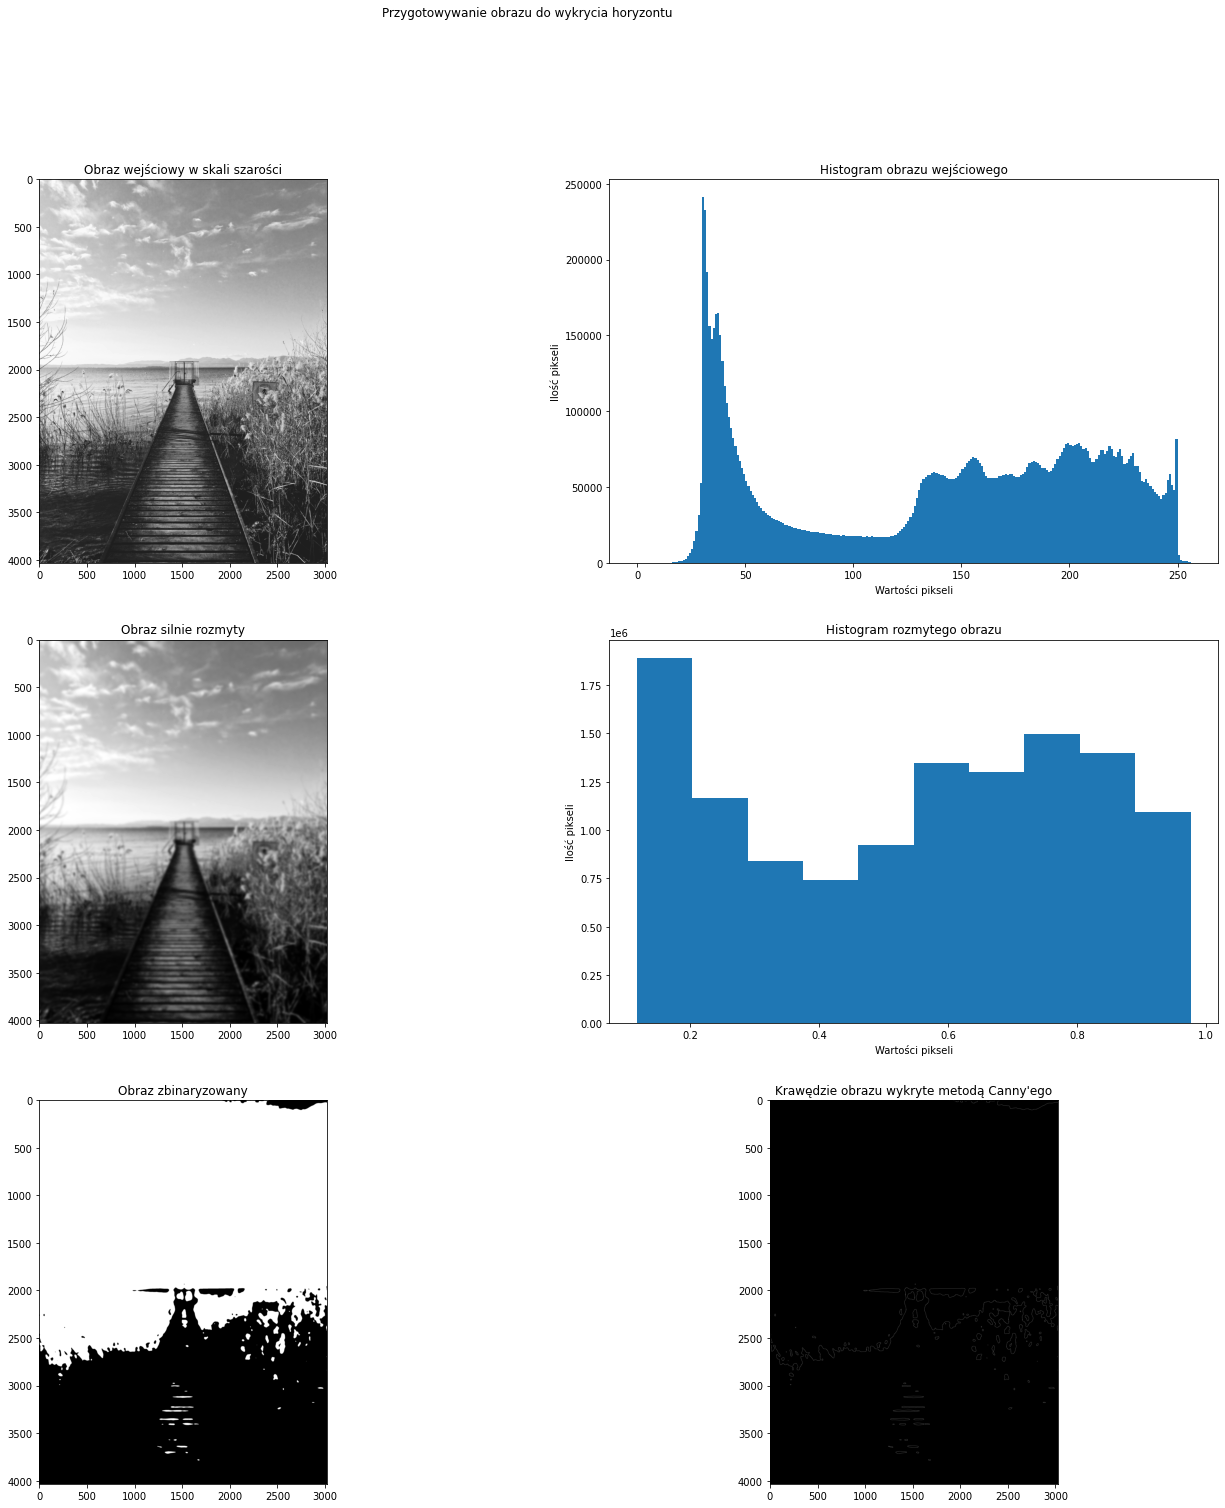

-0.0 (0, 1980) (3024, 1980)


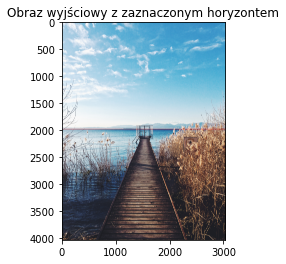

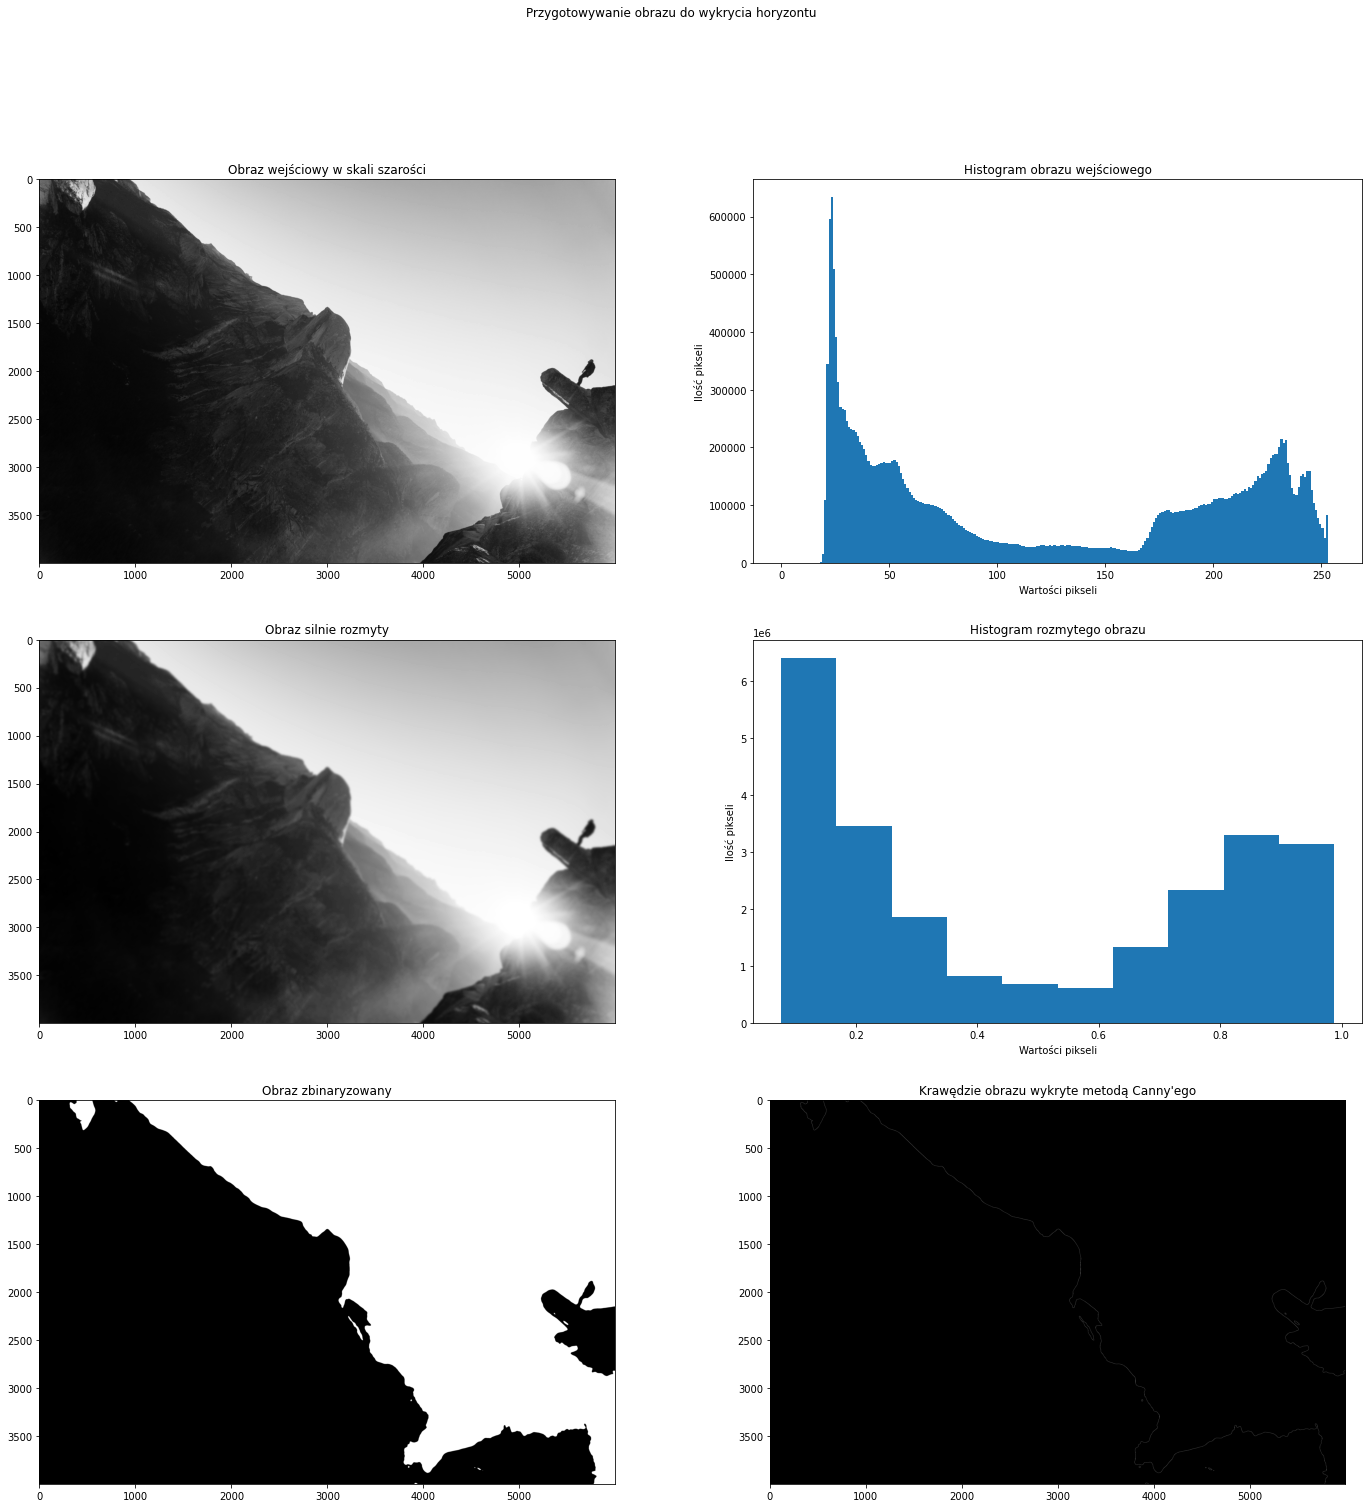

44.245810055865924 (999, 0) (-3106, 4000)


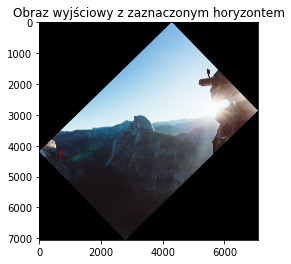

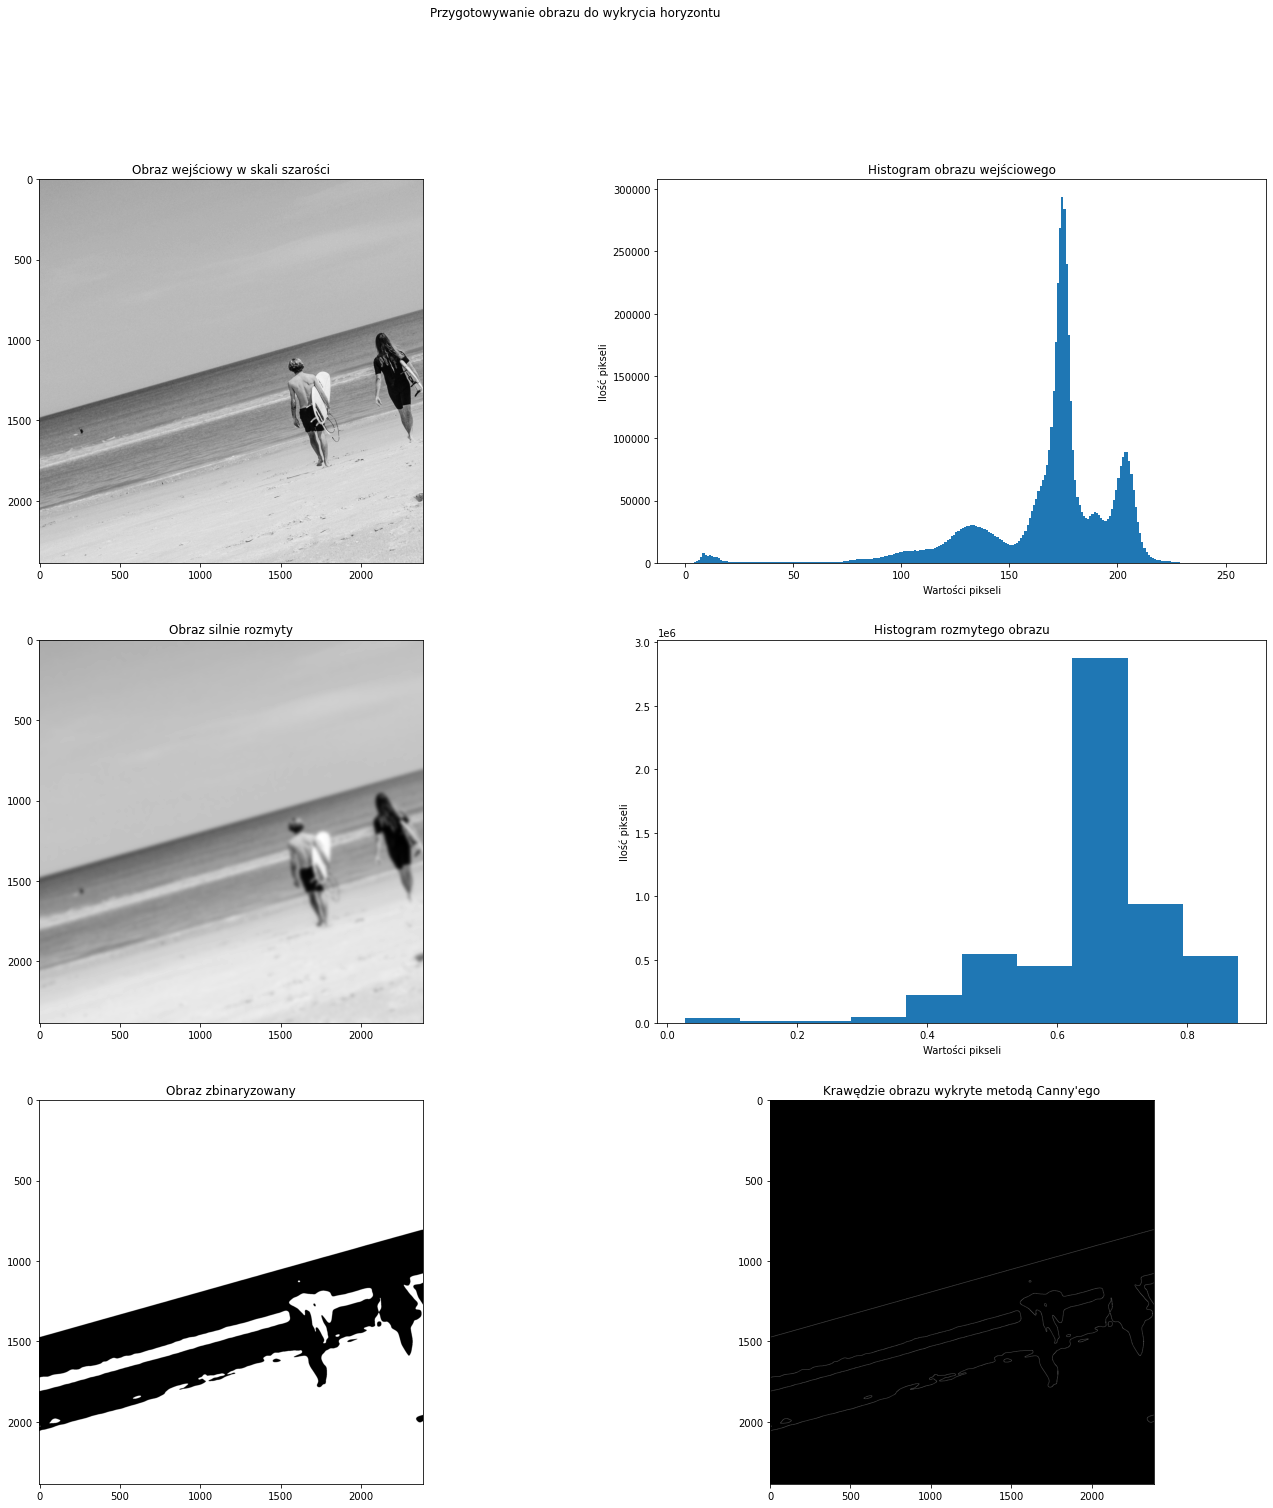

-16.08938547486035 (0, 1476) (2386, 788)


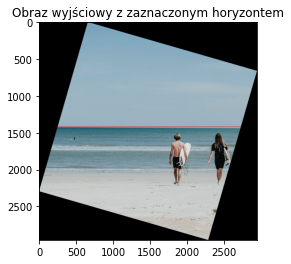

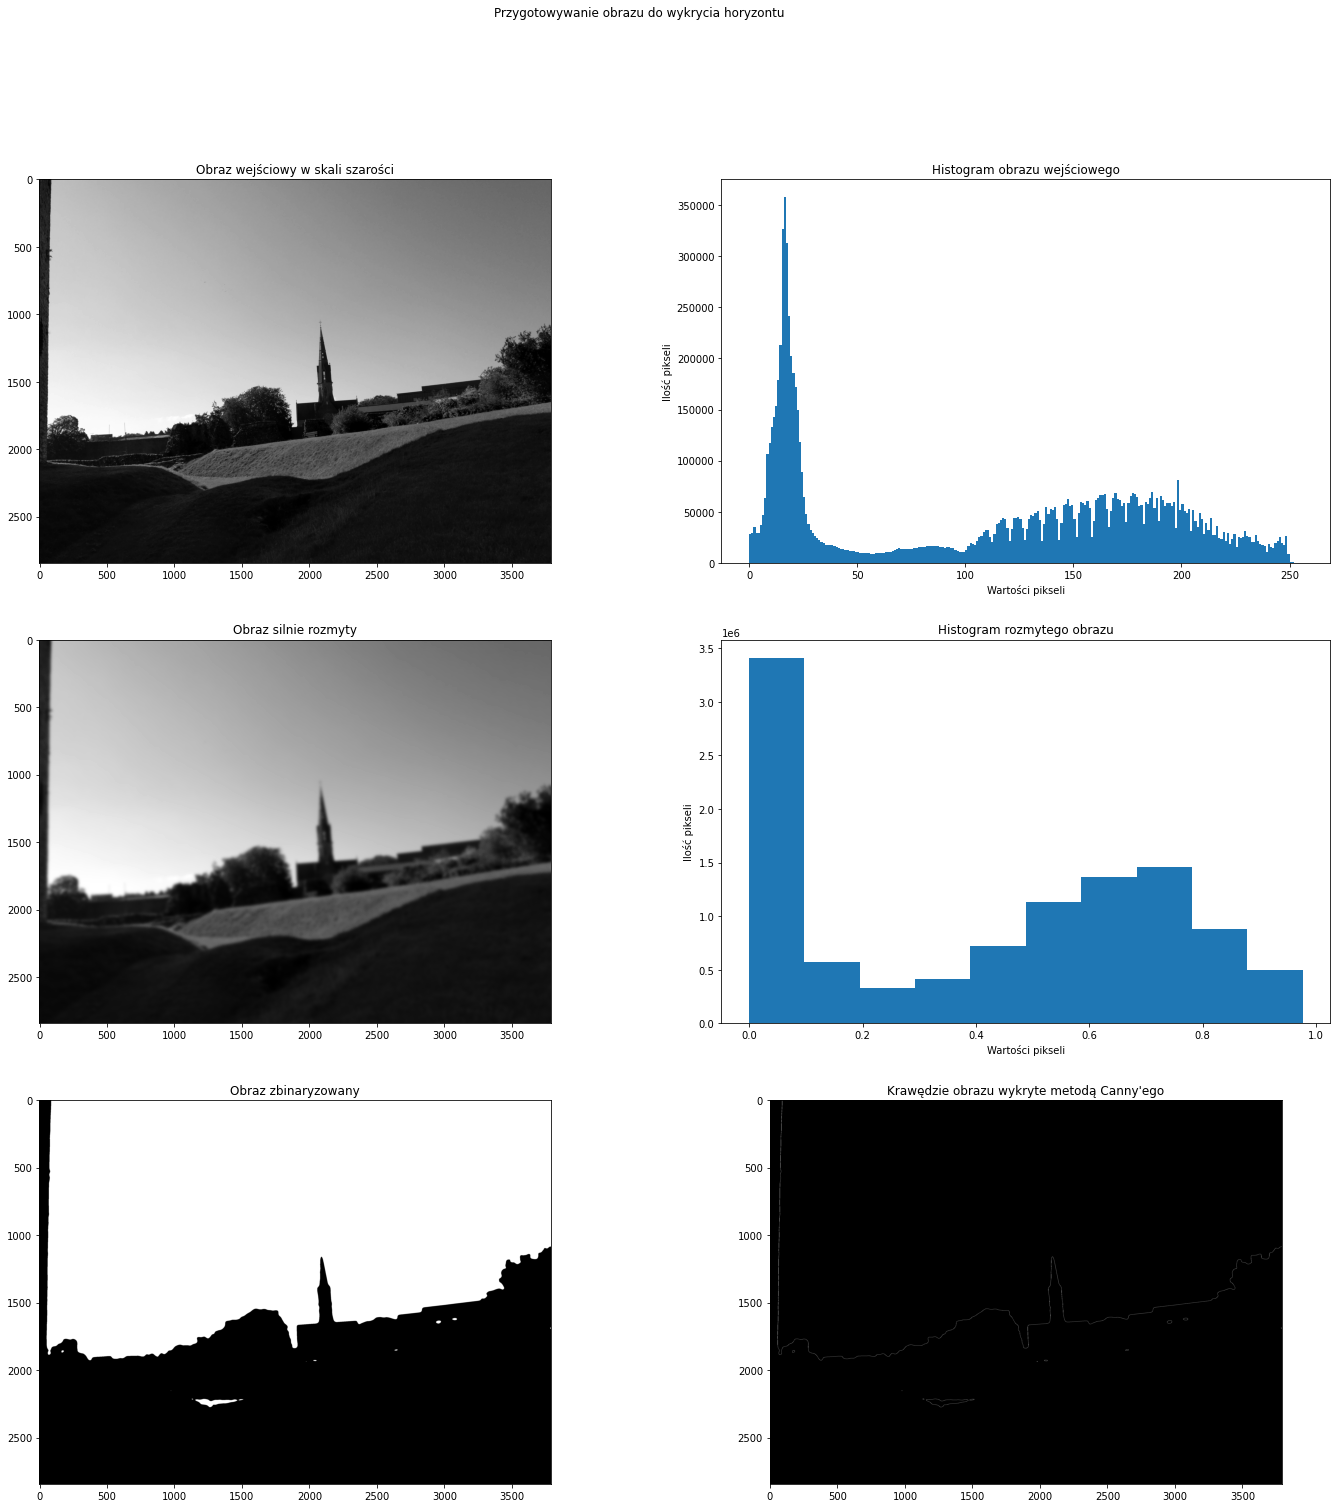

-7.039106145251395 (0, 1887) (3792, 1419)


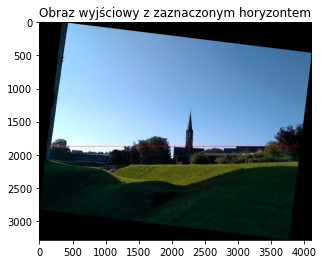

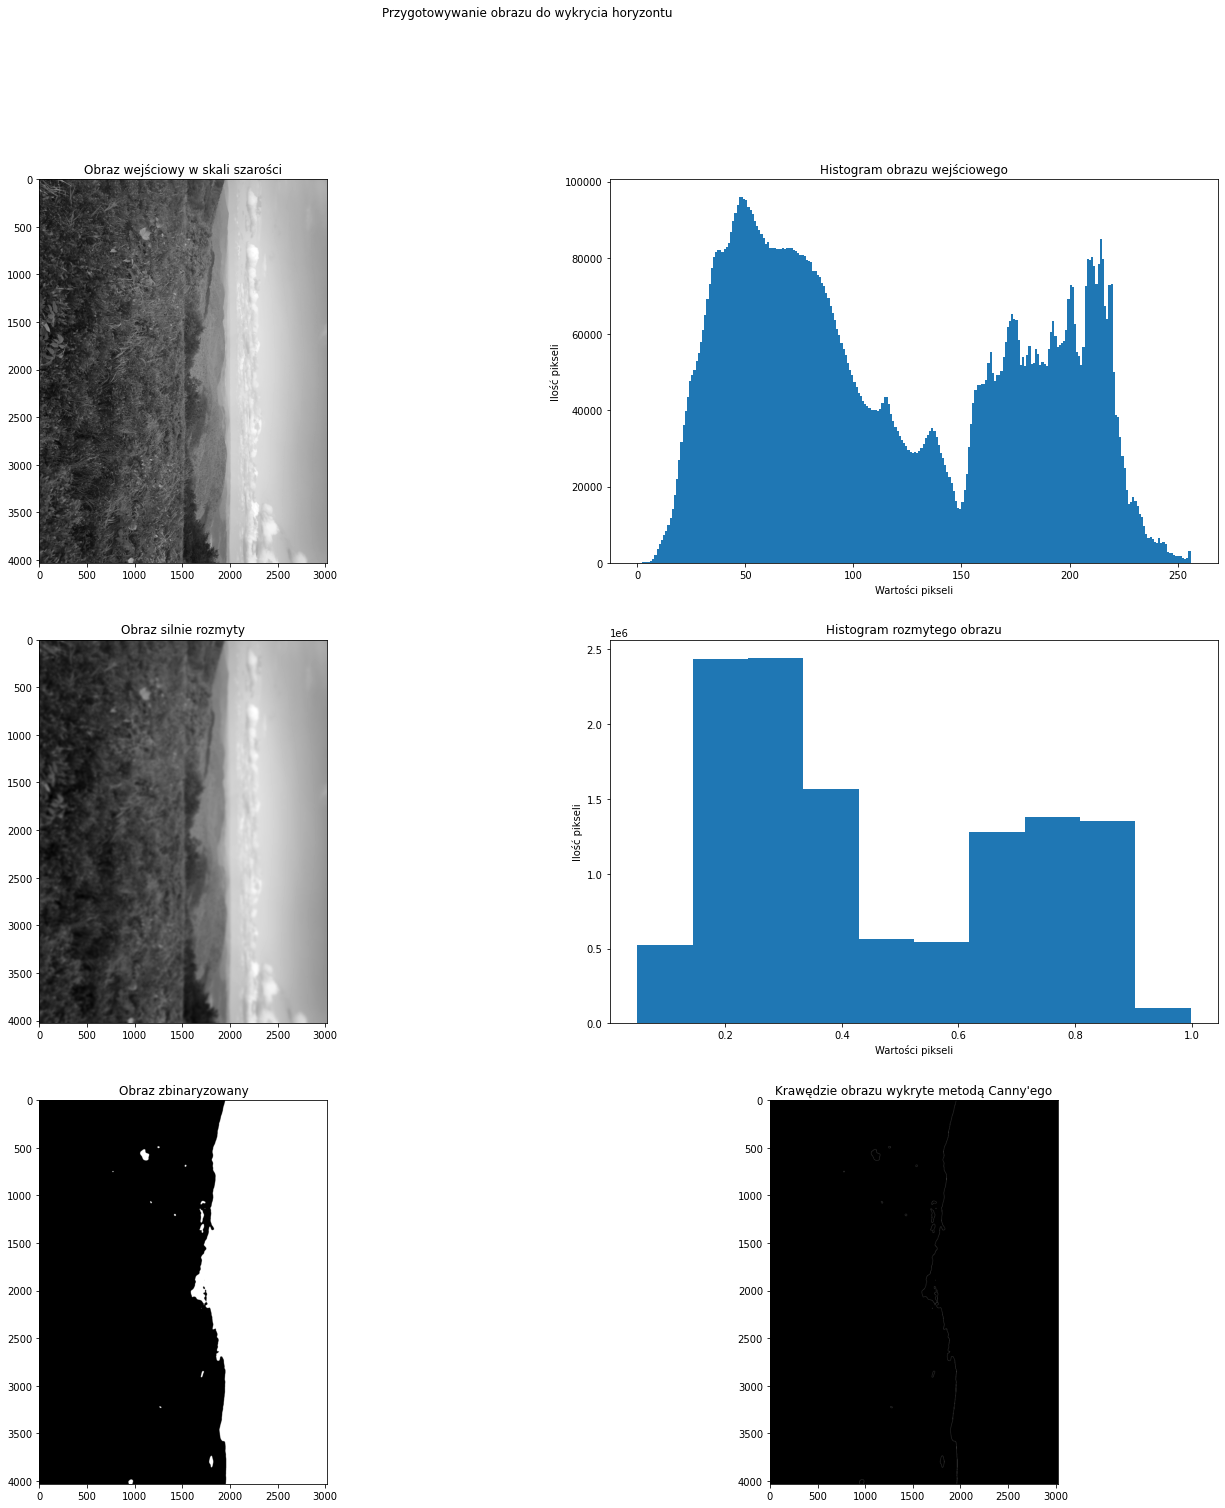

76.42458100558659 (1271, 0) (298, 4030)


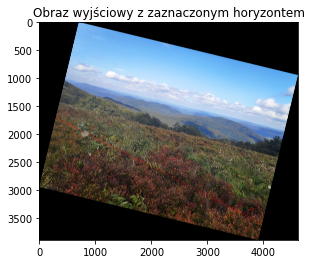

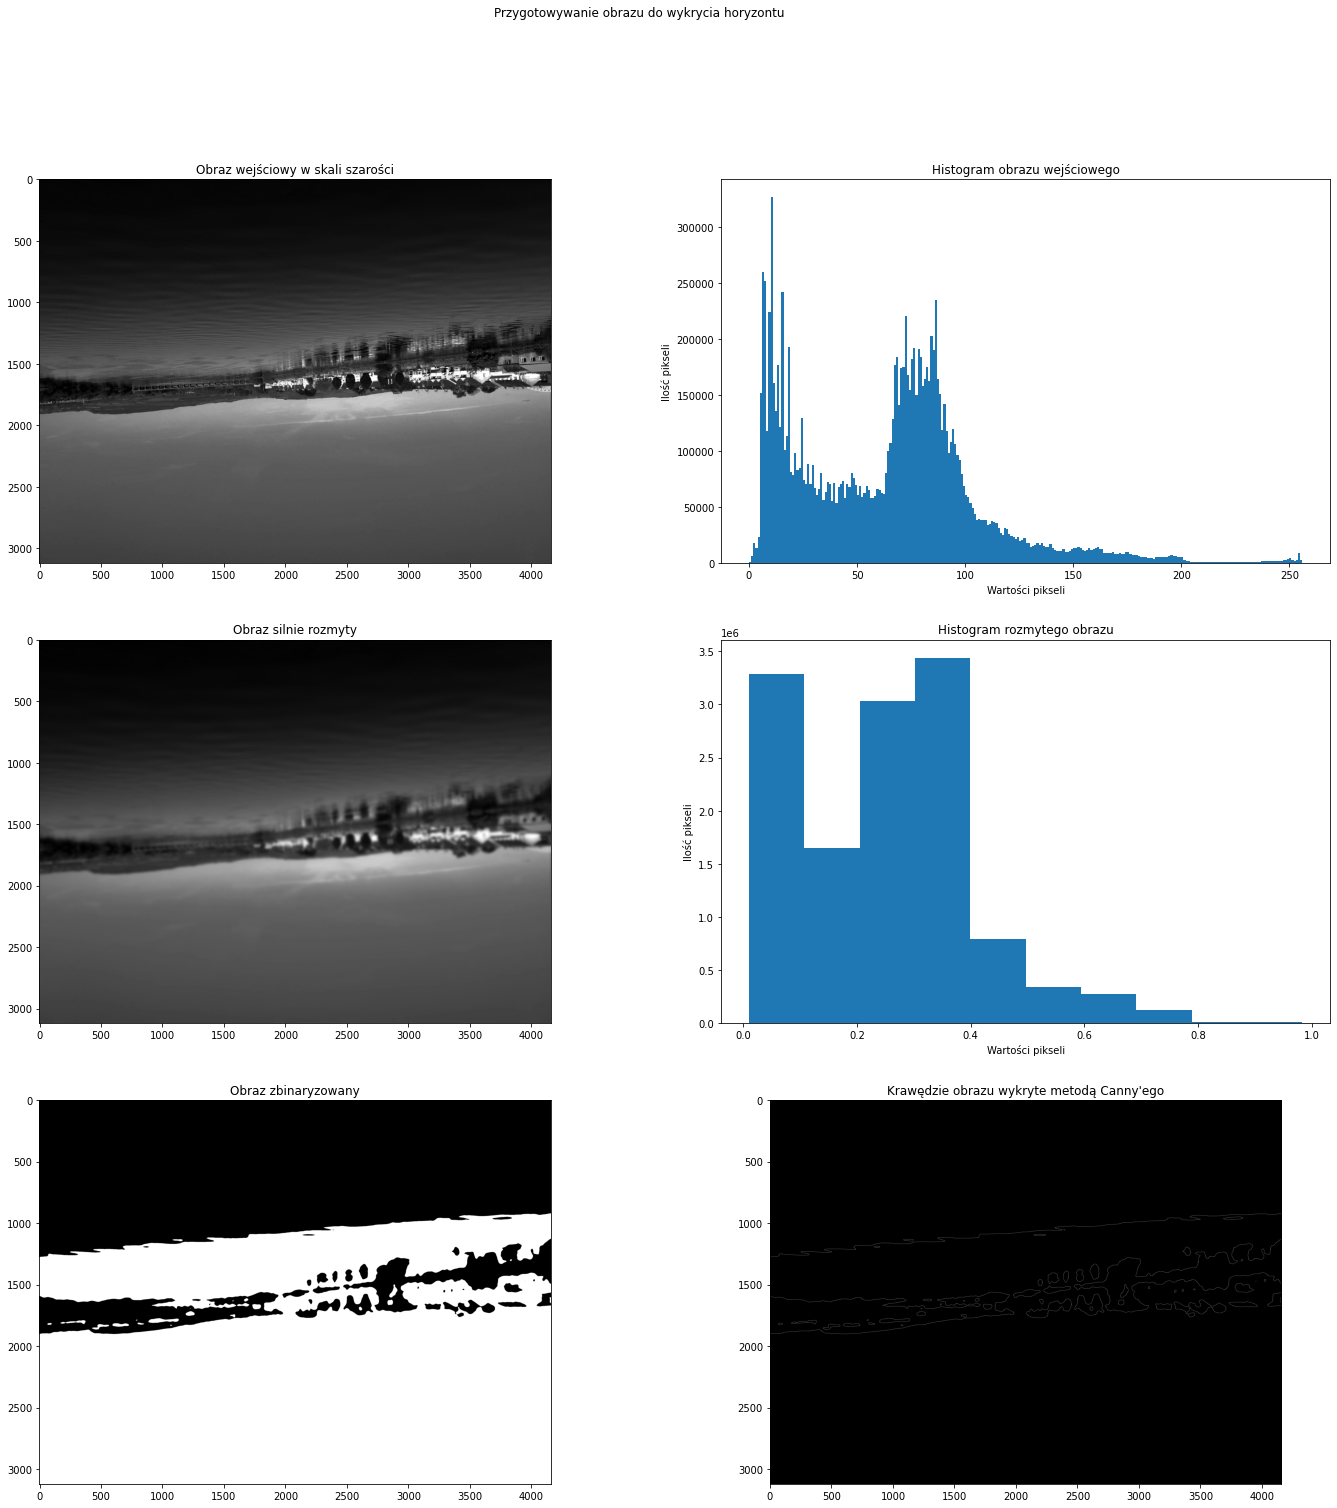

176.98324022346367 (0, 1146) (4158, 927)


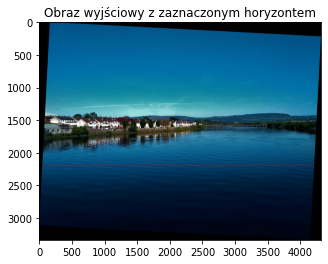

In [ ]:
if __name__ == '__main__':
  for im in input_images:
    image = Image.open(im)
    fixed = find_horizon(image)
    plt.imshow(np.asarray(fixed))
    plt.title("Obraz wyjściowy z zaznaczonym horyzontem")
    fixed.save(root_dir+'output_images/'+im.split('/')[-1])